# Fecha de entrega: 27/08/2022 (corresponde a clase 20)

# Algoritmo de clasificación: Logistic regression

# Diccionario

**BTC_ind_trend_ET_fv** (data set "BTC_ind_trend_ET" reducido según las conclusiones referidas en el punto 7 del documento "Primera entrega")

* Date: fecha en YYYY-MM-DD (object)
* Price: precio de cierre de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
* Open: precio de apertura de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
* High: precio más alto de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
* Low: precio más bajo de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
* Vol.: volumen de BTC (Número de intercambios) en el día de la fecha (float) (Variable numérica continua)
* Percentage_diff: diferencia porcentual del precio de BTC en la fecha [x+1] con respecto a la fecha [x] (float) (Variable numérica continua) 
* Target: 1 indica que en el día de la fecha el precio de BTC subió, y 0 que el precio bajó (float) (Se la tratará como variable categórica)
* EMA_7d: media móvil exponencial de 7 días (USD) (float) (Variable numérica continua)
* HT_TRENDLINE: indicador de Hilbert Transform - Instantaneous Trendline (USD) (float) (Variable numérica continua)
* BBANDS_upper_band: banda superior del indicador Bandas de Bollinger (USD) (float) (Variable numérica continua)
* BBANDS_middle_band: banda media del indicador Bandas de Bollinger (USD) (float) (Variable numérica continua)
* BBANDS_lower_band: banda inferior del indicador Bandas de Bollinger (USD) (float) (Variable numérica continua)
* PSAR: indicador Parabolic SAR (USD) (float) (Variable numérica continua)Price_silver: indica el precio de cierre de la plata en el día de la fecha (float) (USD) (variable numérica continua)
* EMA_7d_ET: valores categóricos de la aplicación de la estrategia de trading EMA de 7 días (comprar, vender, mantener posición) (object) (Variable categórica)
* HT_TRENDLINE_ET: valores categóricos de la aplicación de la estrategia de trading HT Trendline (comprar, vender, mantener posición) (object) (Variable categórica)
* PSAR_ET: valores categóricos de la aplicación de la estrategia de trading PSAR (comprar, vender, mantener posición) (object) (Variable categórica)
* Trend: tendencia de la variable "Price" a lo largo de la serie de tiempo (USD) (Variable categórica continua)
* Residuals: residualidad de la variable "Price" a lo largo de la serie de tiempo (unidad) (Variable categórica continua)

# Librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.cm import ScalarMappable

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data acquisition

In [2]:
def gdriveColabPath(sharing_url):
  file_id=sharing_url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?id=' + file_id
  return dwn_url

## Adquiriendo BTC_ind_trend_ET_fv

In [3]:
# Se carga la base de datos de BTC_ind_trend_ET_fv desde la carpeta compartida en el Google Drive
sharing_url = "https://drive.google.com/file/d/1P7EPcqZ-CGRcTPqhk1BE9KZNTdysCr4A/view?usp=sharing"

In [4]:
dwn_url=gdriveColabPath(sharing_url)
BTC_ind_trend_fv_df = pd.read_csv(dwn_url, sep=";", decimal=".")
BTC_ind_trend_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,EMA_7d_ET,HTTL_ET,PSAR_ET,Trend,Residuals
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,-19.575231
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0.0,NaN,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,15.128694


# Data wrangling

## Análisis pre-modelado

In [5]:
# Registros y columnas
BTC_ind_trend_fv_df.shape

(4386, 19)

In [6]:
# Nombre de columnas
BTC_ind_trend_fv_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'EMA_7d', 'HT_TRENDLINE', 'BBANDS_upper_band',
       'BBANDS_middle_band', 'BBANDS_lower_band', 'PSAR', 'EMA_7d_ET',
       'HTTL_ET', 'PSAR_ET', 'Trend', 'Residuals'],
      dtype='object')

In [7]:
# Tipos de datos de las variables
BTC_ind_trend_fv_df.dtypes

Date                   object
Price                 float64
Open                  float64
High                  float64
Low                   float64
Vol.                  float64
Percentage_diff       float64
Target                float64
EMA_7d                float64
HT_TRENDLINE          float64
BBANDS_upper_band     float64
BBANDS_middle_band    float64
BBANDS_lower_band     float64
PSAR                  float64
EMA_7d_ET              object
HTTL_ET                object
PSAR_ET                object
Trend                 float64
Residuals             float64
dtype: object

In [8]:
# Columnas y cantidad de registros
BTC_ind_trend_fv_df.count()

Date                  4386
Price                 4386
Open                  4386
High                  4386
Low                   4386
Vol.                  4386
Percentage_diff       4386
Target                4386
EMA_7d                4380
HT_TRENDLINE          4323
BBANDS_upper_band     4382
BBANDS_middle_band    4382
BBANDS_lower_band     4382
PSAR                  4385
EMA_7d_ET             4386
HTTL_ET               4386
PSAR_ET               4386
Trend                 4380
Residuals             4380
dtype: int64

In [9]:
# Valores NaN
BTC_ind_trend_fv_df.isnull().sum()

Date                   0
Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Percentage_diff        0
Target                 0
EMA_7d                 6
HT_TRENDLINE          63
BBANDS_upper_band      4
BBANDS_middle_band     4
BBANDS_lower_band      4
PSAR                   1
EMA_7d_ET              0
HTTL_ET                0
PSAR_ET                0
Trend                  6
Residuals              6
dtype: int64

In [10]:
BTC_ind_trend_fv_df.head(10)

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,EMA_7d_ET,HTTL_ET,PSAR_ET,Trend,Residuals
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,-19.575231
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0.0,NaN,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,15.128694
5,2010-07-23,0.1,0.1,0.1,0.1,2400.0,0.0,0.0,NaN,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,10.352268
6,2010-07-24,0.1,0.1,0.1,0.1,500.0,0.0,0.0,0.1,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,0.183737
7,2010-07-25,0.1,0.1,0.1,0.1,1550.0,0.0,0.0,0.1,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,3.979105
8,2010-07-26,0.1,0.1,0.1,0.1,880.0,0.0,0.0,0.1,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,-8.917886
9,2010-07-27,0.1,0.1,0.1,0.1,3370.0,0.0,0.0,0.1,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,-1.150686


Observaciones:

Se observaron varios registros NaN en "BTC_ind_trend_ET_fv.csv". 

Esto implica la necesidad de tomar una decisión con respecto a este tipo de valores (instancia previa al modelado). 

Se descarta rellenar los NaN con promedios de valores previos y/o posteriores por varias razones:

1. En las variables [Trend] y [Residuals], 3 de los 6 valores NaN se encuentran al principio de la serie, y los restantes 3 al final de la misma. Esto significa que no se puede hacer un promedio con valores anteriores y posteriores a los valores NaN sino solo con anteriores o posteriores según el caso. Proceder con un promedio con los datos anteriores o posteriores en una serie de tiempo supone un problema extra (¿cuántos valores hacia atrás o hacia adelante se deben tomar?, ¿cuál es el grado de autocorrelación con los valores anteriores o posteriores?, entre otros). 


2. En la variable [Residuals] hay valores positivos y negativos en los registros anteriores y posteriores inmediatos según el caso. Esto también añade un problema extra (¿qué signo se debería utilizar si se rellenan esos casilleros?).


3. Al no tratarse de un problema de regresión lineal del valor que tomaría el precio de BTC en el registro siguiente sino un problema de clasificación, la eliminación de los valores NaN no afectaría en demasía la predicción del modelo a pesar de la autocorrelación referida en el punto 2. Si se considera eliminar los 63 registros NaN (variable -> HT_TRENDLINE) se estarí solamente eliminando un (63*100/4386 =) 1.43 % de los datos. 

Dado que el modelo no acepta valores NaN se quitarán por las razones aducidas arriba.

## Ultimas manipulaciones pre-modelado

Se reindexa el data set que se modelará a fin de que la variable [Date] funcione como nuevo índice de la base de datos.

In [11]:
# Se crea una copia de BTC_ind_trend_fv_df con nombre BTC_ind_trend y se la reindexa con la variable [Date] como nuevo índice
BTC_ind_trend = BTC_ind_trend_fv_df.set_index("Date")

In [12]:
BTC_ind_trend.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,EMA_7d_ET,HTTL_ET,PSAR_ET,Trend,Residuals
Date,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,1.0,20679.126620,20423.078104,21714.292433,20440.38,19166.467567,22017.409626,Mantener_posicion,Mantener_posicion,Mantener_posicion,21370.371429,-160.287691
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,0.0,20705.744965,20403.832160,21359.693563,20731.32,20102.946437,21894.401241,Mantener_posicion,Mantener_posicion,Mantener_posicion,21784.528571,-994.949467
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,21160.758724,20435.796762,22585.394742,21186.48,19787.565258,18942.200000,Mantener_posicion,Mantener_posicion,Comprar,NaN,NaN
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,1.0,21723.119043,20547.109474,23836.570363,21751.32,19666.069637,19017.654000,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,0.0,22079.614282,20712.814316,24304.381782,22216.12,20127.858218,19207.239840,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN


Dado que en la práctica real solo se tiene hasta los valores del registro anterior al que se quiere predecir se intenta hacer un shift (-1) a la variable [Target]. Se entiende que así (en caso de que el modelo prediga con previsibilidad suficiente) se podría estar seguro de que después vendría el valor de [Target] original sin shift (-1).

In [13]:
# Se genera un back up
BTC_ind_trend_2 = BTC_ind_trend.copy()

In [14]:
# Se realiza el shift 
BTC_ind_trend_2 ["Target"] = BTC_ind_trend ["Target"].shift(-1)

In [15]:
BTC_ind_trend_2.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,EMA_7d_ET,HTTL_ET,PSAR_ET,Trend,Residuals
Date,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,0.0,20679.126620,20423.078104,21714.292433,20440.38,19166.467567,22017.409626,Mantener_posicion,Mantener_posicion,Mantener_posicion,21370.371429,-160.287691
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,1.0,20705.744965,20403.832160,21359.693563,20731.32,20102.946437,21894.401241,Mantener_posicion,Mantener_posicion,Mantener_posicion,21784.528571,-994.949467
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,21160.758724,20435.796762,22585.394742,21186.48,19787.565258,18942.200000,Mantener_posicion,Mantener_posicion,Comprar,NaN,NaN
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,0.0,21723.119043,20547.109474,23836.570363,21751.32,19666.069637,19017.654000,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,NaN,22079.614282,20712.814316,24304.381782,22216.12,20127.858218,19207.239840,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN


Se convierten las variables categóricas ([EMA_7d_ET], [HTTL_ET], [PSAR_ET]) en variables dummies y se agregan a BTC_ind_trend_2

In [16]:
Variables = ["EMA_7d_ET", "HTTL_ET", "PSAR_ET"]

for var in Variables:
    dummies = pd.get_dummies(BTC_ind_trend_2 [var])
    dummies = dummies.rename(columns={"Comprar":"Comprar_"+var+"", "Mantener_posicion":"Mantener_posicion_"+var+"", "Vender":"Vender_"+var+""})
    BTC_ind_trend_2 = pd.concat([BTC_ind_trend_2, dummies], axis = 1)

In [17]:
BTC_ind_trend_2.head()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,EMA_7d_ET,HTTL_ET,PSAR_ET,Trend,Residuals,Comprar_EMA_7d_ET,Mantener_posicion_EMA_7d_ET,Vender_EMA_7d_ET,Comprar_HTTL_ET,Mantener_posicion_HTTL_ET,Vender_HTTL_ET,Comprar_PSAR_ET,Mantener_posicion_PSAR_ET,Vender_PSAR_ET
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN,0,1,0,0,1,0,0,1,0
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN,0,1,0,0,1,0,0,1,0
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,NaN,NaN,0,1,0,0,1,0,0,1,0
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,-19.575231,0,1,0,0,1,0,0,1,0
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0.0,NaN,NaN,0.1,0.1,0.1,0.1,Mantener_posicion,Mantener_posicion,Mantener_posicion,0.1,15.128694,0,1,0,0,1,0,0,1,0


Se eliminan las variables categóricas del BTC_ind_trend_2

In [18]:
BTC_ind_trend_2 = BTC_ind_trend_2.drop(["EMA_7d_ET", "HTTL_ET", "PSAR_ET"], axis=1)

In [19]:
BTC_ind_trend_2.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff', 'Target',
       'EMA_7d', 'HT_TRENDLINE', 'BBANDS_upper_band', 'BBANDS_middle_band',
       'BBANDS_lower_band', 'PSAR', 'Trend', 'Residuals', 'Comprar_EMA_7d_ET',
       'Mantener_posicion_EMA_7d_ET', 'Vender_EMA_7d_ET', 'Comprar_HTTL_ET',
       'Mantener_posicion_HTTL_ET', 'Vender_HTTL_ET', 'Comprar_PSAR_ET',
       'Mantener_posicion_PSAR_ET', 'Vender_PSAR_ET'],
      dtype='object')

Se elimina el registro NaN de la variable [Target] dado que los modelos no pueden procesar este tipo de datos

In [20]:
BTC_ind_trend_2 = BTC_ind_trend_2 [0:4385]

In [21]:
BTC_ind_trend_2.isnull().sum()

Price                           0
Open                            0
High                            0
Low                             0
Vol.                            0
Percentage_diff                 0
Target                          0
EMA_7d                          6
HT_TRENDLINE                   63
BBANDS_upper_band               4
BBANDS_middle_band              4
BBANDS_lower_band               4
PSAR                            1
Trend                           5
Residuals                       5
Comprar_EMA_7d_ET               0
Mantener_posicion_EMA_7d_ET     0
Vender_EMA_7d_ET                0
Comprar_HTTL_ET                 0
Mantener_posicion_HTTL_ET       0
Vender_HTTL_ET                  0
Comprar_PSAR_ET                 0
Mantener_posicion_PSAR_ET       0
Vender_PSAR_ET                  0
dtype: int64

Se eliminan los valores NaN

In [22]:
BTC_ind_trend_2 = BTC_ind_trend_2.dropna()

In [23]:
BTC_ind_trend_2.isnull().sum()

Price                          0
Open                           0
High                           0
Low                            0
Vol.                           0
Percentage_diff                0
Target                         0
EMA_7d                         0
HT_TRENDLINE                   0
BBANDS_upper_band              0
BBANDS_middle_band             0
BBANDS_lower_band              0
PSAR                           0
Trend                          0
Residuals                      0
Comprar_EMA_7d_ET              0
Mantener_posicion_EMA_7d_ET    0
Vender_EMA_7d_ET               0
Comprar_HTTL_ET                0
Mantener_posicion_HTTL_ET      0
Vender_HTTL_ET                 0
Comprar_PSAR_ET                0
Mantener_posicion_PSAR_ET      0
Vender_PSAR_ET                 0
dtype: int64

# Modelado (Logistic regression)

**...Recordando que...**

*Objetivo general del proyecto*

I.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) el dinamismo del precio de Bitcoin en el corto plazo, es decir, si el precio de este criptoactivo subirá o bajará en la temporalidad estudiada (1 día).

**...Recordando que...**

*Objetivo específico del proyecto*

III.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) y a corto plazo, el movimiento alcista o bajista del precio de BTC.

**Explicación**:

En lo que sigue se procederá a realizar varios modelos supervisados de clasificación de tipo "Logistic Regression". 

Estos serán configurados con diversos hiperparámetros a fin de encontrar el resultado más óptimo para este data set.

La variable target del modelo es la columna [Target] de BTC_ind_trend_2.

## Modelo 1

In [24]:
# Se generan las variables X e y (target)
X = BTC_ind_trend_2.drop (["Target"], axis=1)
y = BTC_ind_trend_2 ["Target"].values.reshape(-1,1)

In [25]:
# Se escalan los datos

escalador = MinMaxScaler()

X = escalador.fit_transform(X)

y= escalador.fit_transform(y)

In [26]:
# Se separa la data en train y test
# Se decide aplicar stratify
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                        stratify=y,
                                        test_size=0.3,
                                        random_state=11)

In [27]:
# Creamos una instancia de la Regresión Logística
regresion_logistica = LogisticRegression(class_weight="balanced")

In [28]:
# Entrenamos la regresión logística con los datos de entrenamiento
regresion_logistica.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [29]:
y_train_pred = regresion_logistica.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = regresion_logistica.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.6402116402116402
% de aciertos sobre el set de evaluación es: 0.6342592592592593


[[495 165]
 [309 327]]


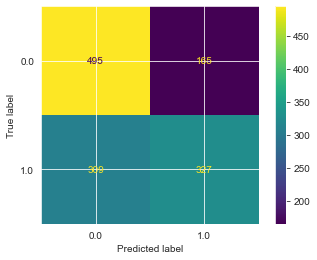

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Predicciones
predictions = regresion_logistica.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(regresion_logistica, X_test, y_test)
plt.show()

Observaciones:
- El modelo predice muy bien los verdaderos negativos pero muy mal los falsos negativos. 

Accuracy of the classifier is: 0.6342592592592593
Precision Score of the classifier is: 0.6646341463414634
Recall Score of the classifier is: 0.5141509433962265
F1 Score of the classifier is: 0.5797872340425533
AUC for our classifier is: 0.6853344768439108


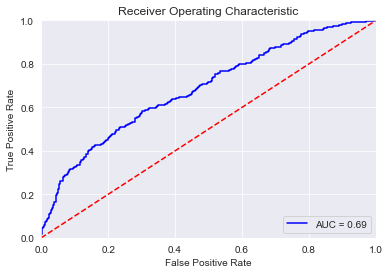

In [31]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = regresion_logistica.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Hypertuning (RandomizedSearchCV)

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
# parameter grid
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'], 
    'C'       : [0.0001,0.001,0.01,0.1,1,10,100, 1000],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'class_weight': ['balanced'],
    'random_state': np.arange(1,10000,100),
    'warm_start':[False, True]
}

In [34]:
from sklearn.model_selection import RandomizedSearchCV
regresion_logistica = LogisticRegression()
regresion_logistica = RandomizedSearchCV(regresion_logistica,
                   parameters,  
                   scoring='accuracy',        
                   cv=5, verbose=2, n_iter=100)

In [35]:
regresion_logistica.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=6501, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=6501, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=6501, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=6501, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=6501, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, random_state=5001, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, random_state=5001, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=1, class_weight=balanced, penalty=l1, random_state=5001, solver=lib

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'class_weight': ['balanced'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101,
       2201, 2301, 2401, 2501, 2601, 2701, 2...
       4401, 4501, 4601, 4701, 4801, 4901, 5001, 5101, 5201, 5301, 5401,
       5501, 5601, 5701, 5801, 5901, 6001, 6101, 6201, 6301, 6401, 6501,
       6601, 6701, 6801, 6901, 7001, 7101, 7201, 7301, 7401, 7501, 7601,
       7701, 7801, 7901, 8001, 8101, 8201, 8301, 8401, 8501, 8601, 8701,
       8801, 8901, 9001, 9101, 9201, 9301, 9401, 9501, 9601, 9701, 9801,
       9901]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear'],
                                        'warm_start': [False, True]},
                   scoring='accuracy', verbose=2)

In [36]:
y_train_pred = regresion_logistica.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = regresion_logistica.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.6785714285714286
% de aciertos sobre el set de evaluación es: 0.6635802469135802


[[525 135]
 [301 335]]


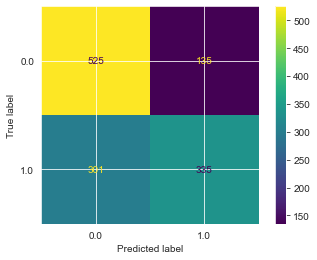

In [37]:
# Predicciones
predictions = regresion_logistica.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(regresion_logistica, X_test, y_test)
plt.show()

Observaciones:
- Se mejoró sustancialmente los valores del recall pero de todas formas el modelo es muy bueno para predicir los verdaderos negativos pero no así los verdaderos positivos.

Accuracy of the classifier is: 0.6635802469135802
Precision Score of the classifier is: 0.7127659574468085
Recall Score of the classifier is: 0.5267295597484277
F1 Score of the classifier is: 0.6057866184448464
AUC for our classifier is: 0.7377644368210405


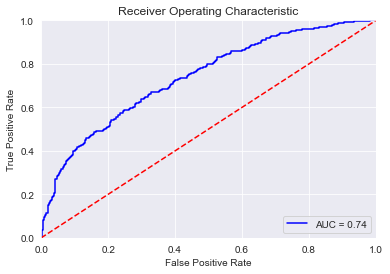

In [38]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = regresion_logistica.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Observaciones:
- El modelo predice en un 66% de los casos si el precio de BTC sube o baja.
- El modelo predice una cantidad elevada de falsos positivos.

Se van a borrar las variables relacionadas con _ET a fin de intentar mejorar las métricas.

In [39]:
BTC_ind_trend_2.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff', 'Target',
       'EMA_7d', 'HT_TRENDLINE', 'BBANDS_upper_band', 'BBANDS_middle_band',
       'BBANDS_lower_band', 'PSAR', 'Trend', 'Residuals', 'Comprar_EMA_7d_ET',
       'Mantener_posicion_EMA_7d_ET', 'Vender_EMA_7d_ET', 'Comprar_HTTL_ET',
       'Mantener_posicion_HTTL_ET', 'Vender_HTTL_ET', 'Comprar_PSAR_ET',
       'Mantener_posicion_PSAR_ET', 'Vender_PSAR_ET'],
      dtype='object')

In [43]:
BTC_ind_trend_2 = BTC_ind_trend_2.drop (['Comprar_EMA_7d_ET',
       'Mantener_posicion_EMA_7d_ET', 'Vender_EMA_7d_ET', 'Comprar_HTTL_ET',
       'Mantener_posicion_HTTL_ET', 'Vender_HTTL_ET', 'Comprar_PSAR_ET',
       'Mantener_posicion_PSAR_ET', 'Vender_PSAR_ET'], axis=1)

In [45]:
BTC_ind_trend_2.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,EMA_7d,HT_TRENDLINE,BBANDS_upper_band,BBANDS_middle_band,BBANDS_lower_band,PSAR,Trend,Residuals
Date,,,,,,,,,,,,,,,
2022-07-13,20250.0,19331.6,20250.8,18942.2,249380.0,4.75,1.0,20330.759396,20482.293636,21936.320395,20395.80,18855.279605,22418.050000,20430.357143,-199.932374
2022-07-14,20586.0,20250.0,20862.2,19664.9,205280.0,1.66,1.0,20394.569547,20473.079091,21246.948738,20195.50,19144.051262,22279.016000,20421.528571,179.600123
2022-07-15,20825.1,20586.1,21178.1,20393.4,164670.0,1.16,1.0,20502.202160,20452.101775,21231.522062,20191.04,19150.557938,22145.543360,20787.614286,47.837982
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,0.0,20679.126620,20423.078104,21714.292433,20440.38,19166.467567,22017.409626,21370.371429,-160.287691
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,1.0,20705.744965,20403.832160,21359.693563,20731.32,20102.946437,21894.401241,21784.528571,-994.949467


In [46]:
X = BTC_ind_trend_2.drop (["Target"], axis=1)
y = BTC_ind_trend_2 ["Target"].values.reshape(-1,1)

In [47]:
# parameter grid
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'], 
    'C'       : [0.0001,0.001,0.01,0.1,1,10,100, 1000],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'class_weight': ['balanced'],
    'random_state': np.arange(1,10000,100),
    'warm_start':[False, True]
}

In [48]:
from sklearn.model_selection import RandomizedSearchCV
regresion_logistica = LogisticRegression()
regresion_logistica = RandomizedSearchCV(regresion_logistica,
                   parameters,  
                   scoring='accuracy',        
                   cv=5, verbose=2, n_iter=100)

In [49]:
regresion_logistica.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=100, class_weight=balanced, penalty=l2, random_state=7601, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, random_state=7601, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, random_state=7601, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, random_state=7601, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, random_state=7601, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, random_state=4301, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, random_state=4301, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, random_state=4301, solve

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'class_weight': ['balanced'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101,
       2201, 2301, 2401, 2501, 2601, 2701, 2...
       4401, 4501, 4601, 4701, 4801, 4901, 5001, 5101, 5201, 5301, 5401,
       5501, 5601, 5701, 5801, 5901, 6001, 6101, 6201, 6301, 6401, 6501,
       6601, 6701, 6801, 6901, 7001, 7101, 7201, 7301, 7401, 7501, 7601,
       7701, 7801, 7901, 8001, 8101, 8201, 8301, 8401, 8501, 8601, 8701,
       8801, 8901, 9001, 9101, 9201, 9301, 9401, 9501, 9601, 9701, 9801,
       9901]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear'],
                                        'warm_start': [False, True]},
                   scoring='accuracy', verbose=2)

In [50]:
y_train_pred = regresion_logistica.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = regresion_logistica.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.6732804232804233
% de aciertos sobre el set de evaluación es: 0.6628086419753086


[[524 136]
 [301 335]]


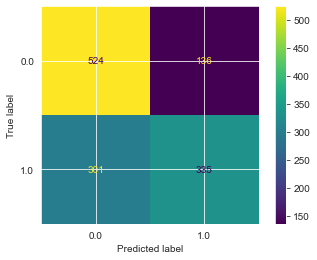

In [51]:
# Predicciones
predictions = regresion_logistica.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(regresion_logistica, X_test, y_test)
plt.show()

Observaciones:
- Se mejoró sustancialmente los valores del recall pero de todas formas el modelo es muy bueno para predicir los verdaderos negativos pero no así los verdaderos positivos.

Accuracy of the classifier is: 0.6628086419753086
Precision Score of the classifier is: 0.7112526539278131
Recall Score of the classifier is: 0.5267295597484277
F1 Score of the classifier is: 0.6052393857271906
AUC for our classifier is: 0.7368663045549839


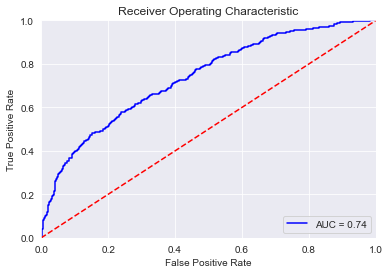

In [52]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = regresion_logistica.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Observaciones:
- El modelo no mejoró.